In [1]:
import pandas as pd
import numpy as np
import csv
import pickle
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
path='/storage/personal_data/hotel_review/train.csv'

In [3]:
df = pd.read_csv(path, encoding='utf-8',engine='python',error_bad_lines=False)

Skipping line 30945: unexpected end of data


In [4]:
df.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30943 entries, 0 to 30942
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User_ID       30943 non-null  object
 1   Description   30943 non-null  object
 2   Browser_Used  30943 non-null  object
 3   Device_Used   30943 non-null  object
 4   Is_Response   30943 non-null  object
dtypes: object(5)
memory usage: 1.2+ MB


In [6]:
df.Is_Response.value_counts()

happy        21109
not happy     9834
Name: Is_Response, dtype: int64

In [7]:
def change_response(data):
    if data == 'not happy':
        return 0
    else:
        return 1

In [8]:
df.drop(columns=['User_ID','Browser_Used','Device_Used'], inplace=True)

In [9]:
df['Is_Response'] = df['Is_Response'].apply(lambda x: change_response(x))

In [10]:
df.head()

,Description,Is_Response
0,The room was kind of clean but had a VERY stro...,0
1,I stayed at the Crown Plaza April -- - April -...,0
2,I booked this hotel through Hotwire at the low...,0
3,Stayed here with husband and sons on the way t...,1
4,My girlfriends and I stayed here to celebrate ...,0


In [34]:
# data from : https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe
df2 = pd.read_csv('negative_reviews.csv')

In [12]:
df2.drop(columns=['Unnamed: 0'], inplace=True)

In [13]:
df2.head()

,Description,Is_Response
0,I am so angry that i made this post available...,0
1,Rooms are nice but for elderly a bit difficul...,0
2,My room was dirty and I was afraid to walk ba...,0
3,You When I booked with your company on line y...,0
4,Backyard of the hotel is total mess shouldn t...,0


In [14]:
df['Is_Response'].value_counts()

1    21109
0     9834
Name: Is_Response, dtype: int64

In [15]:
df2 = df2[:11275]

In [16]:
df = pd.concat([df, df2])

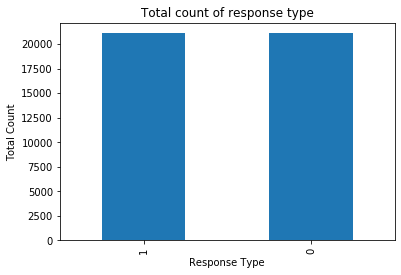

In [35]:
df.groupby('Is_Response').count()['Description'].sort_values(ascending=False).plot(kind='bar')
plt.title('Total count of response type')
plt.ylabel('Total Count')
plt.xlabel('Response Type')
plt.savefig('total_count_response_type_2.png',pi=300, bbox_inches='tight')
plt.show()

In [18]:
df['Is_Response'].value_counts()

1    21109
0    21109
Name: Is_Response, dtype: int64

In [19]:
X_train,X_test,y_train,y_test=train_test_split(df['Description'],df['Is_Response'].values,test_size=0.20)

In [20]:
vocab_size = 500
embedding_dim = 16
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [21]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,maxlen=max_length, 
                                truncating=trunc_type, padding=padding_type)

validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

training_labels_final = np.array(y_train)
validation_labels_final = np.array(y_test)

In [22]:
from keras.regularizers import l2


In [23]:
# CNN model optimum epoch: 10
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Bi-directional LSTM

# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
#                                                        return_sequences=True)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#     tf.keras.layers.Dropout(0.6),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# GRU model

# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
#     tf.keras.layers.Dropout(0.6),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# Model with embedding 
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.GlobalAveragePooling1D(), 
#     tf.keras.layers.Dropout(0.6),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

model.compile(loss='binary_crossentropy',
              optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            8000      
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 16)            1296      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 9,313
Trainable params: 9,313
Non-trainable params: 0
_________________________________________________________________


In [24]:
%%time
num_epochs = 10
history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                    validation_data=(validation_padded, validation_labels_final))

Epoch 1/10
1056/1056 [==============================] - 3s 3ms/step - loss: 0.5364 - accuracy: 0.7376 - val_loss: 0.4405 - val_accuracy: 0.8091
Epoch 2/10
1056/1056 [==============================] - 3s 3ms/step - loss: 0.4693 - accuracy: 0.7919 - val_loss: 0.4190 - val_accuracy: 0.8213
Epoch 3/10
1056/1056 [==============================] - 3s 3ms/step - loss: 0.4546 - accuracy: 0.8000 - val_loss: 0.4129 - val_accuracy: 0.8248
Epoch 4/10
1056/1056 [==============================] - 3s 3ms/step - loss: 0.4466 - accuracy: 0.8023 - val_loss: 0.4154 - val_accuracy: 0.8286
Epoch 5/10
1056/1056 [==============================] - 3s 3ms/step - loss: 0.4375 - accuracy: 0.8087 - val_loss: 0.4123 - val_accuracy: 0.8261
Epoch 6/10
1056/1056 [==============================] - 3s 3ms/step - loss: 0.4333 - accuracy: 0.8109 - val_loss: 0.4226 - val_accuracy: 0.8273
Epoch 7/10
1056/1056 [==============================] - 3s 3ms/step - loss: 0.4267 - accuracy: 0.8138 - val_loss: 0.4219 - val_accuracy:

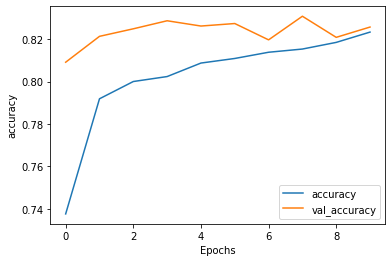

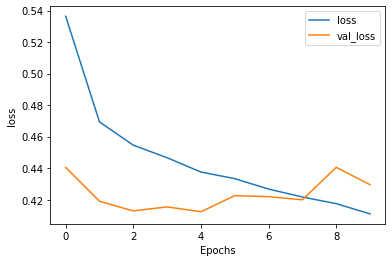

In [25]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [26]:
def predict_sentiment(model, reviews):
    
    padding_type='post'
    sample_sequences = tokenizer.texts_to_sequences(reviews)
    fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length) 
    
    classes = model.predict(fakes_padded)

    # The closer the class is to 1, the more positive the review is deemed to be
    for x in range(len(reviews)):
      print(reviews[x])
      print(classes[x])
      print('\n')

In [27]:
predict_sentiment(model, ['This is the best thing I have ever seen',
                          "Don't think it was all that bad, but some things clearly needs improving"])

This is the best thing I have ever seen
[0.15813357]


Don't think it was all that bad, but some things clearly needs improving
[0.11686078]




In [28]:
# isEnd = False

# while True:
#     val = input('Please enter something')
    
#     if val == 'end':
#         break
        
#     predict_sentiment(model, [val])

In [29]:
# model.save('hotel_review_model.h5')

# with open('tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f)

In [30]:
# tf.keras.models.load_model('hotel_review_model.h5')

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
predictions = model.predict_classes(validation_padded)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [33]:
print(classification_report(validation_labels_final, predictions))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      4173
           1       0.83      0.82      0.83      4271

    accuracy                           0.83      8444
   macro avg       0.83      0.83      0.83      8444
weighted avg       0.83      0.83      0.83      8444

